In [183]:
import seaborn as sns
import numpy as np
import pickle as pkl
import matplotlib as mpl
from graph_tool.generation import lattice
from graph_tool.draw import graph_draw
from itertools import chain
from collections import Counter
from tqdm import tqdm
from copy import copy

from graph_helpers import load_graph_by_name
from viz_helpers import lattice_node_pos
from experiment import gen_input
from helpers import infected_nodes
from core import sample_steiner_trees
from tree_stat import TreeBasedStatistics
from random_steiner_tree.util import from_gt

In [128]:
if False:
    g = lattice((10, 10))
    g.save('data/lattice-100/graph.gt')
else:
    g = load_graph_by_name('lattice-100', weighted=True)

load graph from data/lattice-100/graph_weighted.gt


In [129]:
pos = lattice_node_pos(g, (10, 10))
pos

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x7f36c5e83630, at 0x7f36c5e17da0>

In [130]:
# color related

DEFAULT_COLOR_ID = 7
OBS_COLOR_ID = 4
QUERY_COLOR_ID = 1

DEFAULT_NODE_SIZE = 10
OBS_NODE_SIZE = 20
QUERY_NODE_SIZE = 25

pal = sns.color_palette("Set2", 10)
sns.palplot(pal)

In [192]:
p = g.edge_properties['weights']

if False:
    obs, c = gen_input(
        g, source=None,
        p=p, q=0.1,
        model='ic', min_size=10)

    inf_nodes = infected_nodes(c)
    pkl.dump((obs, c), open('cascade-weighted/lattice-100/1.pkl', 'wb'))
else:
    (obs, c) = pkl.load(open('cascade-weighted/lattice-100/1.pkl', 'rb'))
    
print(len(inf_nodes))
source = np.nonzero(c == 0)[0][0]    

12


In [153]:
def draw_graph(node_color_array):
    node_color = g.new_vertex_property('float')
    for v in np.arange(g.num_vertices()):
        node_color[v] = node_color_array[v]

    vertex_size = g.new_vertex_property('int')
    vertex_size.a[c < 0] = DEFAULT_NODE_SIZE
    vertex_size.a[c >= 0] = OBS_NODE_SIZE

    vertex_order = g.new_vertex_property('int')
    vertex_order.a = (c + 1)

    edge_pen_width = g.new_edge_property('float')
    edge_pen_width.a = p.a * 7.5

    vertex_shape = g.new_vertex_property('string')
    vertex_shape.set_value('circle')
    vertex_shape[source] = 'square'
    graph_draw(g, pos=pos, vertex_fill_color=node_color, vertex_size=vertex_size,
               vorder=vertex_order,
               edge_pen_width=edge_pen_width,
               vertex_shape=vertex_shape,
               vcmap=mpl.cm.Reds)
               # output=fig_root_dir+'/cascade.png')

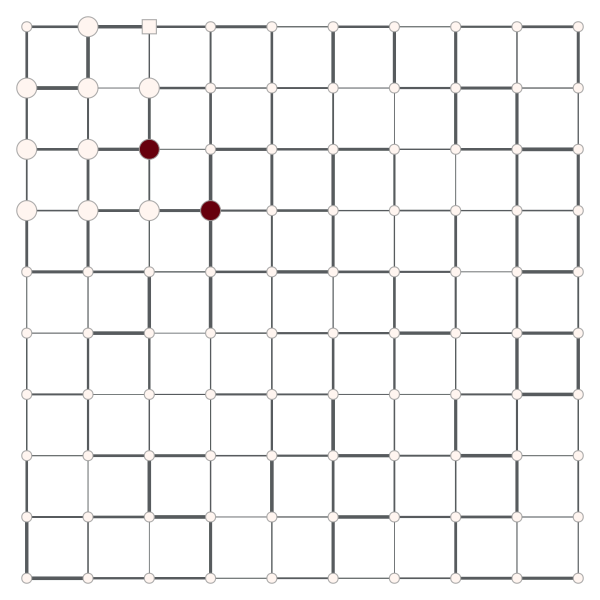

In [154]:
color = np.zeros(g.num_vertices())
color[list(obs)] = 1
draw_graph(color)

In [155]:
n_samples = 100

In [136]:
# method 1
# brute force sampling
brute_force_n_iters = 0
obs = set(obs)
brute_force_samples = []
for i in tqdm(range(n_samples)):
    while True:
        _, c_ = gen_input(
            g, source=source,
            p=p, q=0.1,
            model='ic', min_size=10)
        if obs.issubset(set(infected_nodes(c_))):    
            brute_force_samples.append(c_)
            break
        brute_force_n_iters += 1
print('used {} samples'.format(brute_force_n_iters))        

100%|██████████| 100/100 [00:12<00:00,  4.13it/s]

used 199 samples


In [156]:
freq = np.zeros(g.num_vertices())
for n in chain(*map(infected_nodes, brute_force_samples)):
    freq[n] += 1

In [157]:
brute_force_inf_probas = freq / n_samples

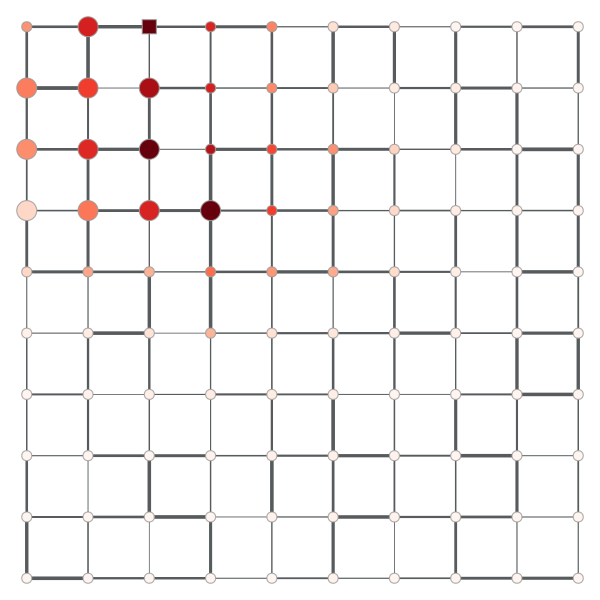

In [158]:
draw_graph(brute_force_inf_probas)

In [171]:
# method 2:
# vanilla steiner tree sampling
gi = from_gt(g)
st_tree_nodes = sample_steiner_trees(g, obs, root=source,
                                     method='loop_erased', n_samples=100, gi=gi, return_tree_nodes=True)

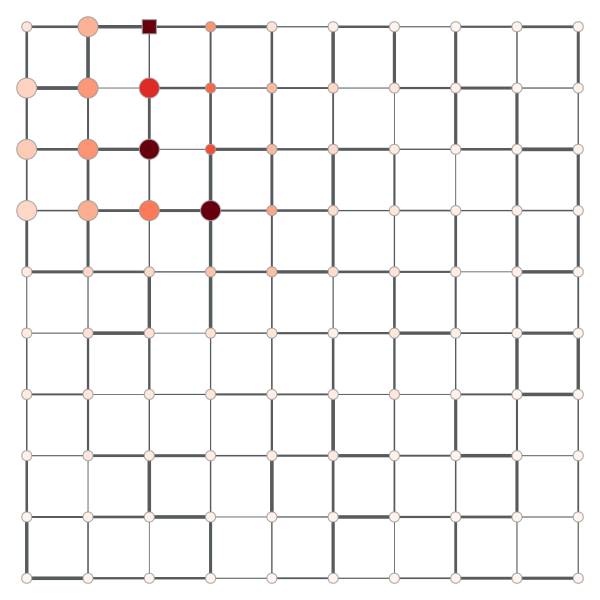

In [172]:
node_stat = TreeBasedStatistics(g, st_tree_nodes)
st_naive_probas = node_stat.unconditional_proba()
draw_graph(st_naive_probas)

In [199]:
# method 3
# with incremental cascade simulation
def incremental_simulation(g, c, p):
    visited = {v: False for v in np.arange(g.num_vertices())}
    new_c = copy(c)
    for v in infected_nodes(c):
        visited[v] = True
    queue = list(infected_nodes(c))
    while len(queue) > 0:
        u = queue.pop(0)
        uu = g.vertex(u)
        for e in uu.out_edges():
            v = int(e.target())        
            if np.random.random() <= p[e] and not visited[v]:  # active
                new_c[v] = c[u] + 1
                visited[v] = True
                queue.append(v)    
    return new_c



In [217]:
sample_steiner_trees(g, obs, root=source,
                     method='loop_erased', n_samples=1, gi=gi, return_tree_nodes=False)

[<GraphView object, undirected, with 6 vertices and 5 edges, edges filtered by (<PropertyMap object with key type 'Edge' and value type 'bool', for Graph 0x7f36c5c77898, at 0x7f36c5c77d30>, 0), vertices filtered by (<PropertyMap object with key type 'Vertex' and value type 'bool', for Graph 0x7f36c5c77898, at 0x7f36c5c77a90>, 0) at 0x7f36c5c77898>]

In [209]:
st_tree_nodes = sample_steiner_trees(g, obs, root=source,
                                     method='loop_erased', n_samples=100, gi=gi, return_tree_nodes=True)
new_tree_nodes = []
for nodes in st_tree_nodes:
    fake_c = np.ones(g.num_vertices()) * (-1)
    fake_c[list(nodes)] = 1
    new_c = incremental_simulation(g, fake_c, p)
    new_tree_nodes.append(infected_nodes(new_c))

In [215]:
st_tree_inc_probas

array([ 0.43,  0.56,  0.56,  0.46,  0.35,  0.15,  0.17,  0.14,  0.11,
        0.08,  0.71,  0.65,  0.71,  0.63,  0.48,  0.34,  0.25,  0.13,
        0.08,  0.07,  1.  ,  0.81,  1.  ,  0.78,  0.53,  0.36,  0.2 ,
        0.12,  0.09,  0.04,  0.67,  0.81,  0.86,  1.  ,  0.75,  0.42,
        0.2 ,  0.12,  0.11,  0.06,  0.56,  0.57,  0.71,  0.59,  0.51,
        0.28,  0.19,  0.17,  0.11,  0.03,  0.23,  0.24,  0.38,  0.48,
        0.42,  0.23,  0.14,  0.13,  0.09,  0.06,  0.12,  0.15,  0.2 ,
        0.21,  0.25,  0.19,  0.12,  0.1 ,  0.09,  0.04,  0.04,  0.1 ,
        0.1 ,  0.13,  0.12,  0.1 ,  0.05,  0.05,  0.05,  0.04,  0.02,
        0.07,  0.1 ,  0.11,  0.09,  0.07,  0.06,  0.05,  0.03,  0.01,
        0.02,  0.03,  0.1 ,  0.09,  0.08,  0.07,  0.05,  0.03,  0.02,  0.  ])

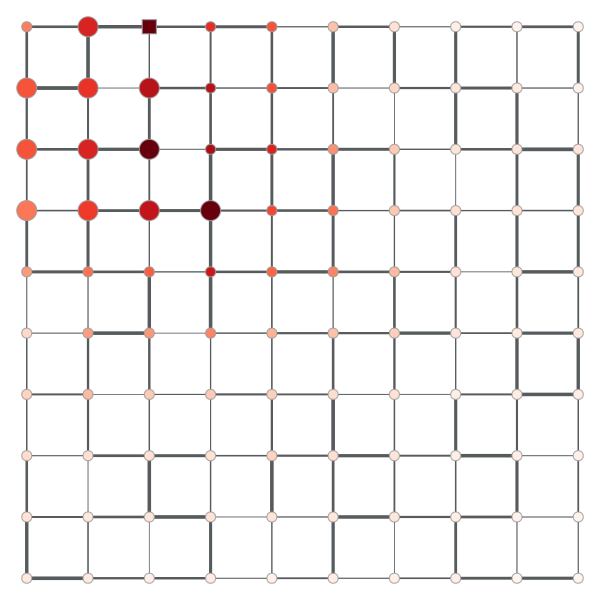

In [212]:
node_stat = TreeBasedStatistics(g, new_tree_nodes)
st_tree_inc_probas = node_stat.unconditional_proba()
draw_graph(st_tree_inc_probas)

In [213]:
# method 4
# method 3 + importance sampling
def tree_